Author: Nicole Mazzitelli Narvaz

The data used for this study were obtained by the Hubble Space Telescope and the MUSE instrument of ESO/VLT. 
Using the MPDAF package, we sliced the original data cube of ESO325 around the central galaxy to obtain only the spectra of interest, which we will be working with.

Here we are analyzing the pixels. We select the central spaxel of the galaxy to validate the implementation for the extraction of kinematics and stellar population.

In [1]:
import glob 
from os import path 
from time import perf_counter as clock
#o módulo glob é usado p listar arquivos/nomes de caminho que correspondam a um padrão especificado.
#os.path implementa algumas funções úteis em nomes de caminho.
#Pra ler ou escrever arquivos, veja open(), e para acessar o sistema de arquivos veja o módulo os.

In [2]:
from astropy.io import fits # usado na astronomia para armazenar imagens e tabelas.
from scipy import ndimage #arrays numpy
import numpy as np

In [3]:
import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util

In [4]:
import matplotlib.pyplot as plt

In [5]:
#def ppxf_example_kinematics_sauron():
ppxf_dir = '/home/nicole/.local/lib/python3.8/site-packages/ppxf' 
eso325_dir = '/home/nicole/eso325/espectros' #caminho da pasta

In [6]:
file = eso325_dir + '/36x43.fits'    #Nome do arquivo
hdu = fits.open(file)                #Abertura do arquivo #This is the top-level FITS object. When a FITS file is opened, a HDUList object is returned.
gal_lin = hdu[1].data                #Fluxo
h1 = hdu[1].header                   #Header
#print(gal_lin)

In [7]:
noise = np.sqrt(hdu[2].data) # tirando raiz da extensão STAT do arquivo FITS(variância de cada medida), calculando ruído como desvio padrão

In [8]:
print(noise)

[111.168846  76.061104  78.43799  ... 104.51989  116.51867         inf]


In [9]:
lamRange1 = h1['CRVAL1'] + np.array([0., h1['CDELT1']*(h1['NAXIS1'] - 1)]) #define comprimento de onda inicial e final em um array.
FWHM_gal = 2.71  #medida do quanto o telesc. consegue separar 2 linhas de absorção que estão próximas.
# SAURON has an instrumental resolution FWHM of 4.2A.
# z = 1.23 # Initial estimate of the galaxy redshift
# lamRange1 = lamRange1/(1+z) # Compute approximate restframe wavelength range
# FWHM_gal = FWHM_gal/(1+z)   # Adjust resolution in Angstrom

In [10]:
print(h1['CDELT1']) # --> 1.25 são os passos de pixel para pixel.

1.25


In [11]:
ind_corte = int((7100 - h1['CRVAL1'])/h1['CDELT1']) #índice do array do espectro que corresponde à 7500 Å, comprimento de onda a partir do qual descartaremos dados fora do intervalo dos templates.

In [12]:
print(ind_corte)

1879


In [13]:
gal_lin = gal_lin[0:ind_corte] #corte do espectro da galáxia entre pixel 0 e ind_corte.
noise = noise[0:ind_corte] #corte do erro na mesma posição. 

In [14]:
np.array([0., h1['CDELT1']*(len(gal_lin) - 1)]) 

array([   0. , 2347.5])

In [15]:
lamRange1 = h1['CRVAL1'] + np.array([0., h1['CDELT1']*(len(gal_lin) - 1)]) #soma do primeiro comp. de onda com o que falta para chegar no último.
print(lamRange1) #1o pixel do espectro corresponde à 4750         

#len gal_lin --> quantos pixels tem no espectro da galáxia

[4750.17382812 7097.67382812]


In [16]:
galaxy_rebin, logLam1, velscale = util.log_rebin(lamRange1, gal_lin) 
galaxy = galaxy_rebin/np.median(galaxy_rebin)  # Normalize o espectro para evitar problemas numéricos
#noise = np.full_like(galaxy, 0.0047)           # Constante ruído por pixel

In [17]:
noise = noise/np.median(galaxy_rebin)

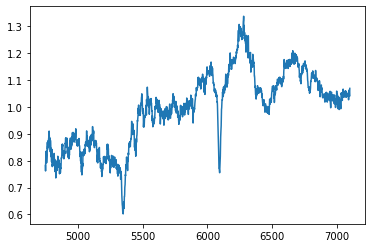

In [18]:
plt.plot (np.exp(logLam1),galaxy)
plt.show()

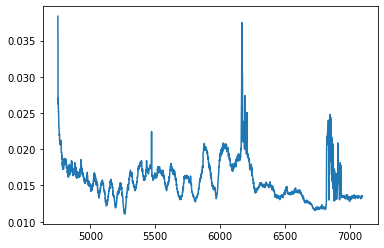

In [19]:
plt.plot (np.exp(logLam1),noise)
plt.show()

In [20]:
# Read the list of filenames from the Single Stellar Population library
# by Vazdekis (2010, MNRAS, 404, 1639) http://miles.iac.es/. A subset
# of the library is included for this example with permission
vazdekis = glob.glob(ppxf_dir + '/miles_models/Mun1.30*.fits') #glob.glob lista todos arquivos do template
FWHM_tem = 2.51  # Vazdekis+10 spectra have a constant resolution FWHM of 2.51A.
velscale_ratio = 2  # adopts 2x higher spectral sampling for templates than for galaxy

In [21]:
# Extract the wavelength range and logarithmically rebin one spectrum
# to a velocity scale 2x smaller than the SAURON galaxy spectrum, to determine
# the size needed for the array which will contain the template spectra.
    
hdu = fits.open(vazdekis[0])
ssp = hdu[0].data     # Speech Signal Processing module
h2 = hdu[0].header
lamRange2 = h2['CRVAL1'] + np.array([0., h2['CDELT1']*(h2['NAXIS1'] - 1)]) 
sspNew, logLam2, velscale_temp = util.log_rebin(lamRange2, ssp, velscale=velscale/velscale_ratio)
templates = np.empty((sspNew.size, len(vazdekis)))

In [22]:
print (lamRange2) #comprimento de onda dos templates. 

[3540.5 7409.6]


In [23]:
# Convolve the whole Vazdekis library of spectral templates
# with the quadratic difference between the SAURON and the
# Vazdekis instrumental resolution. Logarithmically rebin
# and store each template as a column in the array TEMPLATES.

# Quadratic sigma difference in pixels Vazdekis --> SAURON
# The formula below is rigorously valid if the shapes of the
# instrumental spectral profiles are well approximated by Gaussians.
    
FWHM_dif = np.sqrt(FWHM_gal**2 - FWHM_tem**2) #piorando templates para ficar parecido com galaxias.
sigma = FWHM_dif/2.355/h2['CDELT1']  # Sigma difference in pixels

In [24]:
for j, file in enumerate(vazdekis): #j = 149
    hdu = fits.open(file)
    ssp = hdu[0].data
    ssp = ndimage.gaussian_filter1d(ssp, sigma) #degrada template # axis = -1, cval = 0.0, truncate = 4.0
    sspNew, logLam2, velscale_temp = util.log_rebin(lamRange2, ssp, velscale=velscale/velscale_ratio) 
    templates[:, j] = sspNew/np.median(sspNew)  # Normalizes templates

In [25]:
# The galaxy and the template spectra do not have the same starting wavelength.
# For this reason an extra velocity shift DV has to be applied to the template
# to fit the galaxy spectrum. We remove this artificial shift by using the
# keyword VSYST in the call to PPXF below, so that all velocities are
# measured with respect to DV. This assume the redshift is negligible.
# In the case of a high-redshift galaxy one should de-redshift its
# wavelength to the rest frame before using the line below (see above).

c = 299792.458  #Speed of light in km/s
dv = (np.mean(logLam2[:velscale_ratio]) - logLam1[0])*c  # km/s  # dv = -92777.66322243382

In [26]:
z = 0.035  # Initial redshift estimate of the galaxy
goodPixels = util.determine_goodpixels(logLam1, lamRange2, z)

In [27]:
goodPixels #mascara algumas linhas de emissão. queremos somente linhas de absorção. 

array([   0,    1,    2, ..., 1876, 1877, 1878])

In [28]:
# Here the actual fit starts. The best fit is plotted on the screen.
# Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.

vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017) #vel = 449.3517573723122
start = [vel, 200.]  # (km/s), starting guess for [V, sigma] --> com estimativa inicial p/ parâmetros LOSVD
t = clock() #t = 2220.969080546

 Best Fit:       Vel     sigma
 comp.  0:     10003       492
chi2/DOF: 3.332; degree = 6; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150


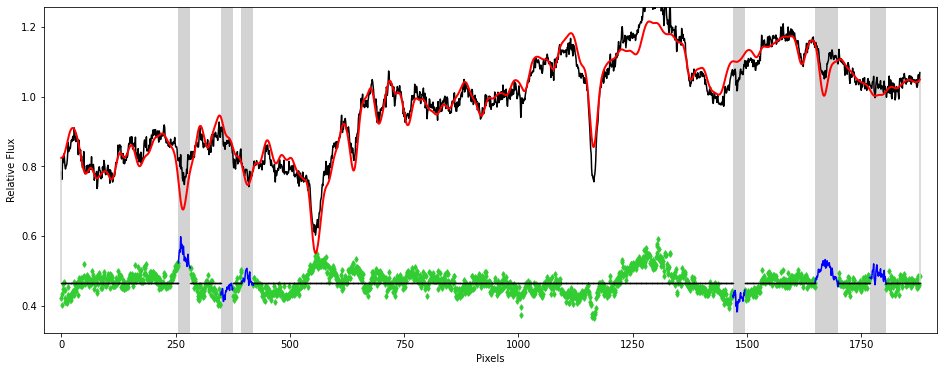

In [29]:
plt.figure(figsize=(16,6))
pp = ppxf(templates, galaxy, noise, velscale, start,
              goodpixels=goodPixels, plot=True, moments=2,
              degree=6, vsyst=dv, velscale_ratio=velscale_ratio) #vsyst --> vel. sistemática da expansão do universo
#chi2 = ideia de quão bom o ajuste está / DOF = grau liberdade  #degree --> melhora ajuste 

In [30]:
print("Formal errors:")
print("     dV    dsigma   dh3      dh4")
print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))
  
print('Elapsed time in pPXF: %.2f s' % (clock() - t))

# If the galaxy is at significant redshift z and the wavelength has been
# de-redshifted with the three lines "z = 1.23..." near the beginning of
# this procedure, the best-fitting redshift is now given by the following
# commented line (equation 2 of Cappellari et al. 2009, ApJ,704, L34;
# http://adsabs.harvard.edu/abs/2009ApJ...704L..34C) 

print(pp.sol)

Formal errors:
     dV    dsigma   dh3      dh4
      11      11
Elapsed time in pPXF: 0.69 s
[10002.72434487   491.97506697]
